# Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import json
import re 
import requests
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from spotipy import oauth2
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

We'll be using the spotipy API to access Spotify https://spotipy.readthedocs.io/en/2.16.1/#

We'll need to set up our application with Spotify to create a Client ID and Secret ID https://developer.spotify.com/dashboard/applications

In [2]:
cid ="cid" 
secret = "secret"
redirect_uri = 'https://localhost:8888/callback'

In [71]:
SPOTIPY_CLIENT_ID = cid
SPOTIPY_CLIENT_SECRET = secret
SCOPE = ('user-read-recently-played,user-library-read,user-read-currently-playing,playlist-read-private,playlist-modify-private,playlist-modify-public,user-read-email,user-modify-playback-state,user-read-private,user-read-playback-state')
SPOTIPY_REDIRECT_URI = redirect_uri
sp_oauth = oauth2.SpotifyOAuth( SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET,SPOTIPY_REDIRECT_URI,scope=SCOPE )

# log in to your spotify account in the new tab
code = sp_oauth.get_auth_response(open_browser=True)
token = sp_oauth.get_access_token(code)
refresh_token = token['refresh_token']
sp = spotipy.Spotify(auth=token['access_token'])
username = sp.current_user()['id']

# browser will redirected to new tab, need to copy url of new tab to log in

current_user_info = sp.current_user()
username = current_user_info['id']
displayname = current_user_info['display_name']

print('Display Name: ', displayname) 
print('User ID: ', username)

Enter the URL you were redirected to: https://accounts.spotify.com/authorize?client_id=be4d6cda1d4f4e0cbfac207c581836e4&response_type=code&redirect_uri=https%3A%2F%2Flocalhost%3A8888%2Fcallback&scope=user-read-recently-played%2Cuser-library-read%2Cuser-read-currently-playing%2Cplaylist-read-private%2Cplaylist-modify-private%2Cplaylist-modify-public%2Cuser-read-email%2Cuser-modify-playback-state%2Cuser-read-private%2Cuser-read-playback-state
Display Name:  Justin Laws
User ID:  1260618695


In [73]:
def get_user_playlists():
    
    # Create a dictionary with the user's playlist names and ID's
    playlist_names = []
    playlist_ids = []
    
    
    playlists = sp.current_user_playlists(limit=50, offset=0)
    playlists = playlists['items']
    
    for i in range(len(playlists)):
        playlist_names.append(playlists[i]['name'])
        playlist_ids.append(playlists[i]['id'])
        
    # Adding loop to gather playlists if user has more than 50 playlists 
    
    offset = 50
    while (len(playlists) == 50):
        playlists = sp.current_user_playlists(limit=50, offset=offset)
        playlists = playlists['items']

        for i in range(len(playlists)):
            playlist_names.append(playlists[i]['name'])
            playlist_ids.append(playlists[i]['id'])
        offset = offset + 50
    
    
    user_playlist_dict = dict(zip(playlist_names, playlist_ids))


    return user_playlist_dict

def select_user_playlist():
    print("Please select a playlist:")
    
    user_playlists = get_user_playlists()
    options = list(user_playlists.keys())

    for idx, element in enumerate(options):
        print("{}) {}".format(idx + 1, element))

    i = input("Enter number: ")
    try:
        if 0 < int(i) <= len(options):
            i = int(i) -1
    except:
        pass
    
    selected_playlist_name = options[i]
    selected_playlist_id = user_playlists[selected_playlist_name]

    print('Selected playlist: ', selected_playlist_name)
    
    return selected_playlist_id

playlist_id = select_user_playlist()

Please select a playlist:
1) Test Playlist 2
2) Test Playlist
3) Test Creation 2
4) Test Creation
5) Test Sample
6) Baby Favs
7) Baby Groove
8) Guitar Greatness
9) Justin's 2022 Top Songs
10) Your Top Songs 2022
11) Baby Albums
12) Baby Rock
13) Chill Delivery 😎
14) Electronic
15) Your Top Songs 2021
16) New Groove
17) Discovery
18) edcorlando21
19) Your Top Songs 2020
20) Vapor
21) Awesome Sauce
22) Release Radar
23) Discover Weekly
24) Rock
25) Funky
26) Trippy
27) Chill
28) The Sound of Vapor Twitch
29) Your Top Songs 2019
30) Modern Mash
31) Imagery
32) Digital Fire
33) Realpolitik
34) Existential Drift
35) Dreams in Time
36) Carnival Rock
37) Instrumental
38) Western Imagination
39) Pump Up
40) Dark
41) Pop Alt
42) alternative
43) Zahra
44) everything emerson thinks is good about music intended for Justin Laws to enjoy
45) Liked from Radio
Enter number: 9
Selected playlist:  Justin's 2022 Top Songs


In [74]:
def get_playlist_df(playlistid, username=username):
    
    
    targetplaylist = sp.user_playlist(username, playlistid)
    
    print('Importing Playlist: ', targetplaylist['name'])
       
    target_tracks = targetplaylist["tracks"]
    target_songs = target_tracks["items"] 
    
    # Spotify will return 100 tracks at a time, so we need to gather the additional songs
    
    while target_tracks['next']:
        target_tracks = sp.next(target_tracks)
        for item in target_tracks["items"]:
            target_songs.append(item)
        
    name = []
    id_number = []
    artists =[]
    album =[]
    duration_ms = [] 
    popularity = []

    for i in range(len(target_songs)):
        id_number.append(target_songs[i]['track']['id'])
        name.append(target_songs[i]['track']['name'])
        artists.append(target_songs[i]['track']['artists'])
        album.append(target_songs[i]['track']['album'])
        duration_ms.append(target_songs[i]['track']['duration_ms'])
        popularity.append(target_songs[i]['track']['popularity'])
     
    playlist_df = zip(id_number, name, artists, album, popularity, duration_ms)
    
    playlist_df = pd.DataFrame(playlist_df, columns=['id', 'name', 'artists',  'album', 'popularity', 'duration_ms'])
        
    return playlist_df    

In [75]:
target_playlist = get_playlist_df(playlist_id)
print('Shape: ', target_playlist.shape)
target_playlist.head(n=2)

Importing Playlist:  Justin's 2022 Top Songs
Shape:  (89, 6)


,id,name,artists,album,popularity,duration_ms
0,0YP50JeZs2Kas2djHSYQFT,Hold On,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",42,250813
1,0nulkrtTeEYJ5975HPHWkV,Ghost Blood (with MXMS),[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",43,222963


In [100]:
len(top_tracks_df['artists_ids'][0])

1

## Artist Info

In [105]:
def get_artist_info(playlistdf):
    
    artists = list(playlistdf['artists'])

    arist_names = []
    artist_IDs =[]

    for i in range(len(artists)):
        names = []
        aggregrated_ids = []

        for p in range(len(artists[i])):
            names.append(artists[i][p]['name'])
            aggregrated_ids.append(artists[i][p]['id'])

        arist_names.append(names)
        artist_IDs.append(aggregrated_ids)

    playlistdf['artists_names'] = arist_names
    playlistdf['artists_ids'] = artist_IDs

    artist_lengths = []
    for i in range(len(playlistdf['artists_ids'])):
        artist_lengths.append(len(playlistdf['artists_ids'][i])) 
    max_artists = max(artist_lengths)
    max_artists

    artist_names_list = []

    for i in range(max_artists):
        artist_names_string = 'artist_name' + str(i+1)
        artist_names_list.append(artist_names_string)

    artist_names_df = pd.DataFrame(playlistdf['artists_names'].to_list(), columns = artist_names_list)
    playlistdf = playlistdf.merge(artist_names_df, left_index=True, right_index=True)




        
    return playlistdf

target_playlist = get_artist_info(target_playlist)
target_playlist.head(n=2)

,id,name,artists,album,popularity,duration_ms,artists_names,artists_ids,artist_name1_x,artist_name2_x,artist_name3_x,artist_name4_x,album_name,album_id,album_realease_date,album_type,Artist_Genres,danceability,energy,key,mode,speechiness,instrumentalness,acousticness,loudness,liveness,valence,tempo,time_signature,All_artists,artist_name1_y,artist_name2_y,artist_name3_y,artist_name4_y,artist_name1,artist_name2,artist_name3,artist_name4
0,0YP50JeZs2Kas2djHSYQFT,Hold On,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",42,250813,[Knowmads],[6aUKy2LG1OU6KhYOZADolN],Knowmads,None,None,None,Into The Sunset,20yvdNDJTpvjE1BBeK8H6R,2021-05-21,album,"[indie pop rap, pop rap, seattle hip hop, unde...",0.848,0.447,3,1,0.0510,0.297000,0.572,-7.655,0.108,0.314,99.966,4,"[Knowmads, None, None, None]",Knowmads,None,None,None,Knowmads,None,None,None
1,0nulkrtTeEYJ5975HPHWkV,Ghost Blood (with MXMS),[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",43,222963,"[Saint Punk, MXMS]","[0oad1RRAiN1UpaOWbIB0EW, 385fK73L7PCt3RMlZQOu6t]",Saint Punk,MXMS,None,None,Ouroboros,5KhjG8zlztHfeyn4NI8bly,2021-09-24,album,"[dark clubbing, game mood, dark pop, indie pop...",0.701,0.683,1,0,0.0363,0.000698,0.150,-5.055,0.390,0.138,122.941,4,"[Saint Punk, MXMS, None, None]",Saint Punk,MXMS,None,None,Saint Punk,MXMS,None,None


## Album Info 

In [78]:
def get_album_info(playlistdf):
    
    # take a add album information
    
    albums = list(playlistdf['album'])
    
    album_name = []
    album_id = []
    album_realease_date = []
    album_type = []
    
    for i in albums:
        album_name.append(i['name'])
        album_id.append(i['id'])
        album_realease_date.append(i['release_date'])
        album_type.append(i['album_type'])
        
    playlistdf['album_name'] = album_name
    playlistdf['album_id'] = album_id
    playlistdf['album_realease_date'] = album_realease_date
    playlistdf['album_type'] = album_type

        
    return playlistdf

target_playlist = get_album_info(target_playlist)
target_playlist.head(n=2)

,id,name,artists,album,popularity,duration_ms,artists_names,artists_ids,artist_name1,artist_name2,artist_name3,artist_name4,album_name,album_id,album_realease_date,album_type
0,0YP50JeZs2Kas2djHSYQFT,Hold On,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",42,250813,[Knowmads],[6aUKy2LG1OU6KhYOZADolN],Knowmads,None,None,None,Into The Sunset,20yvdNDJTpvjE1BBeK8H6R,2021-05-21,album
1,0nulkrtTeEYJ5975HPHWkV,Ghost Blood (with MXMS),[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",43,222963,"[Saint Punk, MXMS]","[0oad1RRAiN1UpaOWbIB0EW, 385fK73L7PCt3RMlZQOu6t]",Saint Punk,MXMS,None,None,Ouroboros,5KhjG8zlztHfeyn4NI8bly,2021-09-24,album


## Genre info

Spotify doesn't have individual song genres, so we have to access the genres by artist or album. While gathering the genre by album would be ideal, many albums, especially singles, do not have any genre labels. So we'll focus on pulling the genre by the artist, and some artists might not have genre info at all.

In [80]:
def get_song_genres(playlistdf, get_album_genres=False): 
    
    # Get genres from artists
    artist_genres = []
    
    # We'll create a dictionary to store the artist ID's and genres. This will prevent us from having to make repeated calls to the Spotify API.
    # This isn't strictly necessary for smaller playlists, but it will be helpful after we gather multiple songs from the same artist to create our pool of possible reccomendations
    artist_genre_dict = {'Arist ID':'Genres'}
    
    n = 0
    o = 0
    
    for i in playlistdf['artists_ids']:
        genres = []
        for j in range(len(i)):
            artist_id = i[j]
            
            # Check the dictionary to see if the artist genres have already been added. If so, then we'll pull the genres from the dict to avoid calling the api
            if artist_id in artist_genre_dict:
                genres.extend(artist_genre_dict[artist_id])
                n = n +1
            else:    
                artist_ob = sp.artist(artist_id)
                target_genres = artist_ob['genres']
                genres.extend(target_genres)
                artist_genre_dict.update({artist_id:target_genres})
                o = o+1
            
        artist_genres.append(genres)
        
    playlistdf['Artist_Genres'] = artist_genres
    
    # to reduce the number of requests, we'll keep the album genre as False by default
    if get_album_genres == True:
        # Get genres from album
        album_genres = []

        for i in playlistdf['album_id']:
            album_ob = sp.album(i)
            album_genres.append(album_ob['genres'])

        playlistdf['Album_Genres'] = album_genres
        
    print('Spotify calls: ', o, 'Dict calls: ', n)

    
    return playlistdf

target_playlist = get_song_genres(target_playlist)
target_playlist.head(n=2)

Spotify calls:  127 Dict calls:  17


,id,name,artists,album,popularity,duration_ms,artists_names,artists_ids,artist_name1,artist_name2,artist_name3,artist_name4,album_name,album_id,album_realease_date,album_type,Artist_Genres
0,0YP50JeZs2Kas2djHSYQFT,Hold On,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",42,250813,[Knowmads],[6aUKy2LG1OU6KhYOZADolN],Knowmads,None,None,None,Into The Sunset,20yvdNDJTpvjE1BBeK8H6R,2021-05-21,album,"[indie pop rap, pop rap, seattle hip hop, unde..."
1,0nulkrtTeEYJ5975HPHWkV,Ghost Blood (with MXMS),[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",43,222963,"[Saint Punk, MXMS]","[0oad1RRAiN1UpaOWbIB0EW, 385fK73L7PCt3RMlZQOu6t]",Saint Punk,MXMS,None,None,Ouroboros,5KhjG8zlztHfeyn4NI8bly,2021-09-24,album,"[dark clubbing, game mood, dark pop, indie pop..."


## Features

In [81]:
def get_song_features(playlistdf):

    
    features = []
    
    # sp.audio_features is limited to 50 songs per request
    for i in range(0,len(playlistdf['id']),50):
        audio_features = sp.audio_features(playlistdf['id'][i:i+50])
        for j in audio_features:
            features.append(j)
            
    danceability = []
    energy =[]
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    time_signature = []
    
    
    for i in range(len(features)):
        
            # Not all songs have features data
            
            try:
                danceability.append(features[i]['danceability'])
                energy.append(features[i]['energy'])
                key.append(features[i]['key'])
                loudness.append(features[i]['loudness'])
                mode.append(features[i]['mode'])
                speechiness.append(features[i]['speechiness'])
                acousticness.append(features[i]['acousticness'])
                instrumentalness.append(features[i]['instrumentalness'])
                liveness.append(features[i]['liveness'])
                valence.append(features[i]['valence'])
                tempo.append(features[i]['tempo'])
                time_signature.append(features[i]['time_signature'])
            except:
                danceability.append(np.nan)
                energy.append(np.nan)
                key.append(np.nan)
                loudness.append(np.nan)
                mode.append(np.nan)
                speechiness.append(np.nan)
                acousticness.append(np.nan)
                instrumentalness.append(np.nan)
                liveness.append(np.nan)
                valence.append(np.nan)
                tempo.append(np.nan)
                time_signature.append(np.nan)
                
            
    playlistdf['danceability'] = danceability
    playlistdf['energy'] = energy
    playlistdf['key'] = key
    playlistdf['mode'] = mode
    playlistdf['speechiness'] = speechiness
    playlistdf['instrumentalness'] = instrumentalness
    playlistdf['acousticness'] = acousticness
    playlistdf['loudness'] = loudness
    playlistdf['liveness'] = liveness
    playlistdf['valence'] = valence
    playlistdf['tempo'] = tempo
    playlistdf['time_signature'] = time_signature

    
    return playlistdf

target_playlist = get_song_features(target_playlist)
target_playlist.head(n=2)
    

,id,name,artists,album,popularity,duration_ms,artists_names,artists_ids,artist_name1,artist_name2,artist_name3,artist_name4,album_name,album_id,album_realease_date,album_type,Artist_Genres,danceability,energy,key,mode,speechiness,instrumentalness,acousticness,loudness,liveness,valence,tempo,time_signature
0,0YP50JeZs2Kas2djHSYQFT,Hold On,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",42,250813,[Knowmads],[6aUKy2LG1OU6KhYOZADolN],Knowmads,None,None,None,Into The Sunset,20yvdNDJTpvjE1BBeK8H6R,2021-05-21,album,"[indie pop rap, pop rap, seattle hip hop, unde...",0.848,0.447,3,1,0.0510,0.297000,0.572,-7.655,0.108,0.314,99.966,4
1,0nulkrtTeEYJ5975HPHWkV,Ghost Blood (with MXMS),[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",43,222963,"[Saint Punk, MXMS]","[0oad1RRAiN1UpaOWbIB0EW, 385fK73L7PCt3RMlZQOu6t]",Saint Punk,MXMS,None,None,Ouroboros,5KhjG8zlztHfeyn4NI8bly,2021-09-24,album,"[dark clubbing, game mood, dark pop, indie pop...",0.701,0.683,1,0,0.0363,0.000698,0.150,-5.055,0.390,0.138,122.941,4


# Top Artists

In [85]:
def artist_columns(playlistdf):
    artist_number = 0
    for i in list(playlistdf.keys()):
        if 'artist_name' in i:
            artist_number = artist_number + 1
    
    artist_names_columns = []
    artist_ids_columns = []
    genre_names_columns = []
    
    for i in range(artist_number):
        string = 'artist_name'
        string = string + str(i+1)
        artist_names_columns.append(string)        
        
        string = 'ArtistID_'
        string = string + str(i+1)
        artist_ids_columns.append(string)
        
        string = 'genre_'
        string = string + str(i+1)
        genre_names_columns.append(string)
               
    return(artist_names_columns, artist_ids_columns, genre_names_columns)


 

In [86]:
def analyze_artists(playlistdf, target_number=5):

    artist_names_columns = artist_columns(playlistdf)[0]

    playlistdf['All_artists'] = [[e for e in row if e==e] for row in playlistdf[artist_names_columns].values.tolist()] # iterate over nan values to combine all the artists into in a list 

    target_artists = []

    for i, artists in enumerate(playlistdf['artists_names']):
            for g in range(len(artists)):     
                target_artists.append(artists[g]) 

    top_artists = Counter(target_artists).most_common(target_number)
    labels = [item[0] for item in top_artists]
    number = [item[1] for item in top_artists]
    nbars = len(top_artists)

    artist = []
    instances = []
    for i in range(target_number):
        artist.append(top_artists[i][0])
        instances.append(top_artists[i][1])

    top_artists = zip(artist, instances)
    top_artists = set(top_artists)

    top_artists_df = pd.DataFrame(top_artists, columns=['Artist', 'Instances'])

    top_artists_df['Instances'] = top_artists_df['Instances'].astype(int)
    top_artists_df = top_artists_df.sort_values('Instances', ascending = False)  

    single_instance_mask = top_artists_df['Instances'] != 1
    top_artists_df = top_artists_df[single_instance_mask]
    top_artists_df = top_artists_df.reset_index()
    top_artists_df = top_artists_df.drop(columns = 'index')

    top_artists_plot = plt.figure(figsize=(22, 5))
    plt.bar(np.arange(nbars), number, tick_label=labels)
    plt.xticks(rotation='vertical')

    
    return(top_artists_df, top_artists_plot)


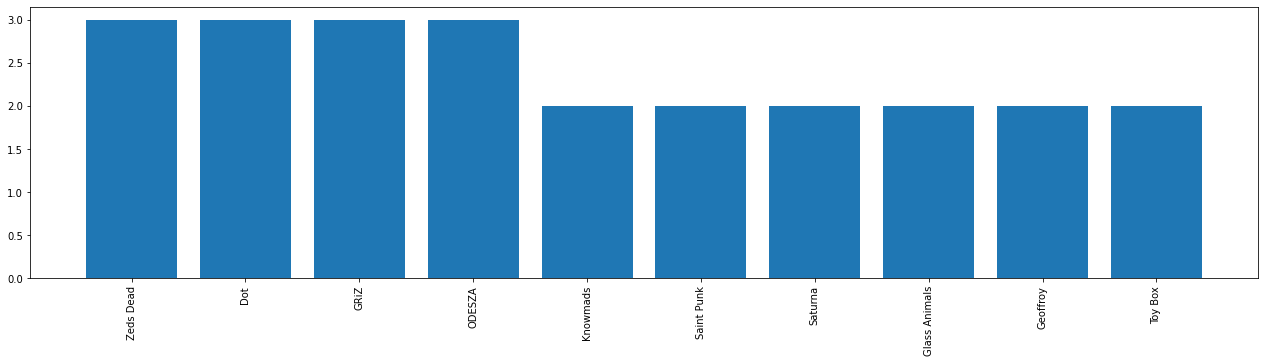

In [87]:
top_artists = analyze_artists(target_playlist, target_number=10)
top_artists_df = top_artists[0]
top_artists_plot = top_artists[1];

top_artists_plot;

# Top Genres

In [88]:
def analyze_genres(playlistdf, target_number=5):

    target_genres = []
    for i, genres in enumerate(playlistdf['Artist_Genres']):
            for g in range(len(genres)):     
                target_genres.append(genres[g]) 

    top_genres = Counter(target_genres).most_common(target_number)
    labels = [item[0] for item in top_genres]
    number = [item[1] for item in top_genres]
    nbars = len(top_genres)

    top_genres_plot = plt.figure(figsize=(22, 5))
    plt.bar(np.arange(nbars), number, tick_label=labels)
    plt.xticks(rotation='vertical')

    artist = []
    instances = []
    for i in range(target_number):
        artist.append(top_genres[i][0])
        instances.append(top_genres[i][1])

    top_genres = zip(artist, instances)
    top_genres = set(top_genres)

    top_genres_df = pd.DataFrame(top_genres, columns=['Artist', 'Instances'])

    top_genres_df['Instances'] = top_genres_df['Instances'].astype(int)
    top_genres_df = top_genres_df.sort_values('Instances', ascending = False)  

    single_instance_mask = top_genres_df['Instances'] != 1
    top_genres_df = top_genres_df[single_instance_mask]
    top_genres_df = top_genres_df.reset_index()
    top_genres_df = top_genres_df.drop(columns = 'index')
    
    return(top_genres_df, top_genres_plot)

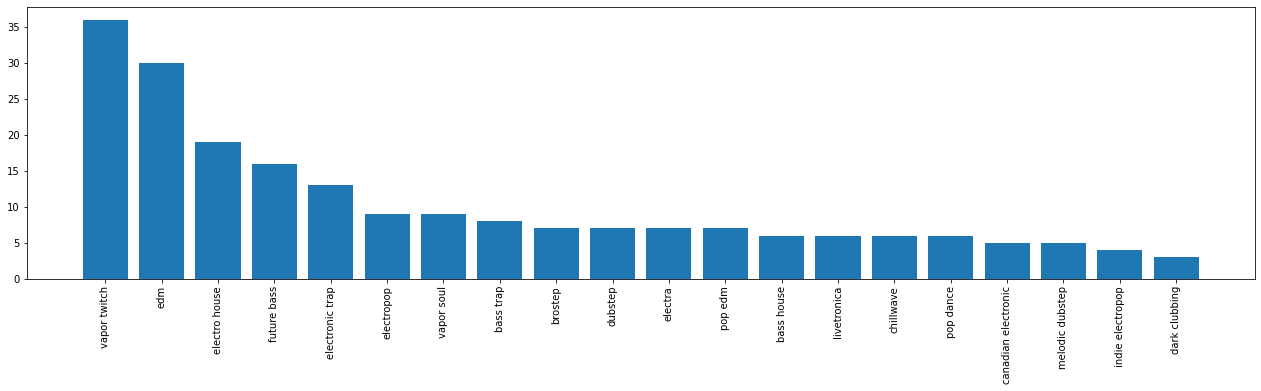

In [89]:
top_genres = analyze_genres(target_playlist, target_number=20)
top_genres_df = top_genres[0]
top_genres_plot = top_genres[1];

top_genres_plot;

# Analyze Features

In [90]:
def analyze_playlist(target_playlist):
    fig = plt.figure(figsize=(14, 10))
    features =['danceability', 'energy', 'loudness', 'valence', 'tempo', 'key']

    a = 2  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize=(20, 8))
 
    for i, feature in enumerate(features):
        target = target_playlist[feature]

        plt.subplot(a, b, c)

        plt.xlabel(feature.title())
        sns.histplot(target, kde=True)
        #plt.legend()
        c = c + 1

    return fig

<Figure size 1008x720 with 0 Axes>

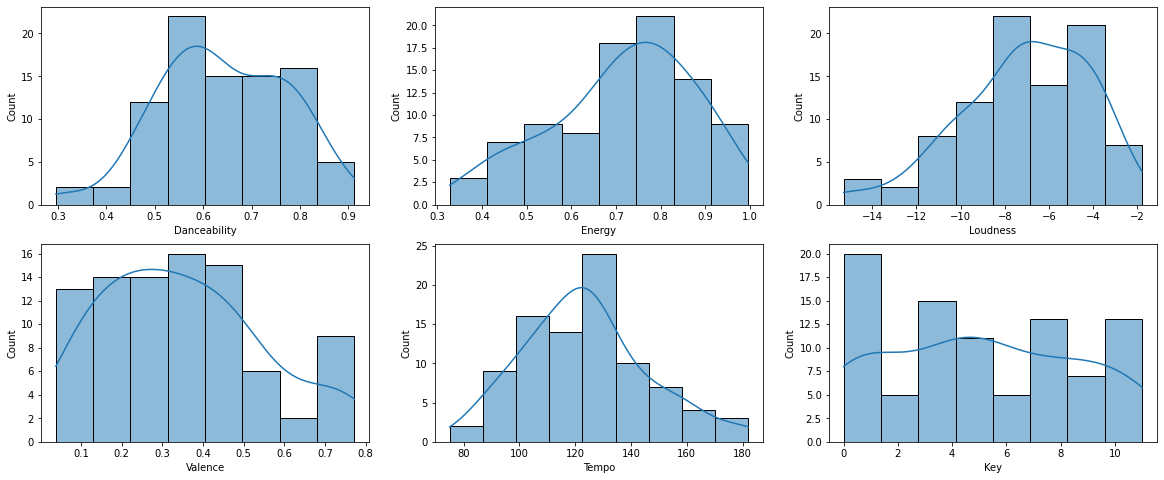

In [91]:
feature_charts = analyze_playlist(target_playlist)
feature_charts;

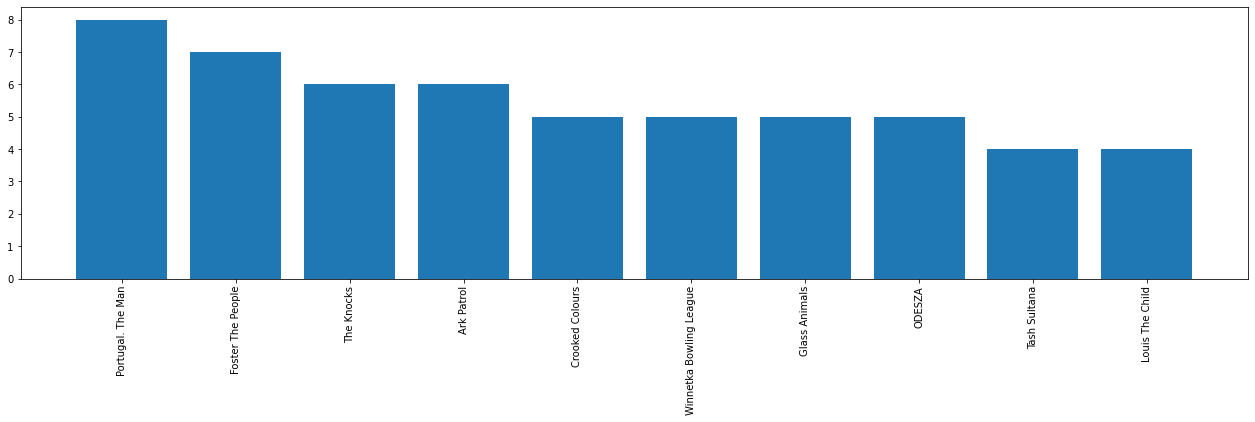

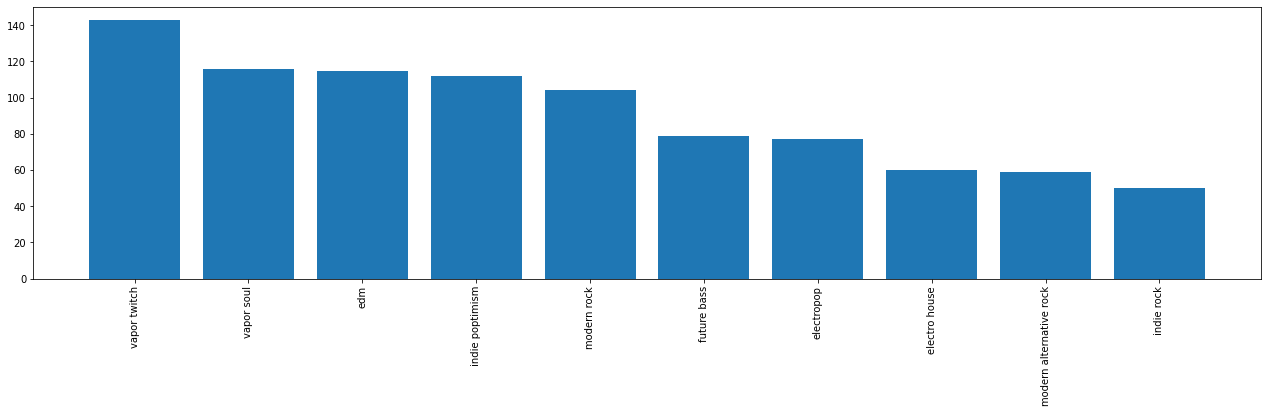

<Figure size 1008x720 with 0 Axes>

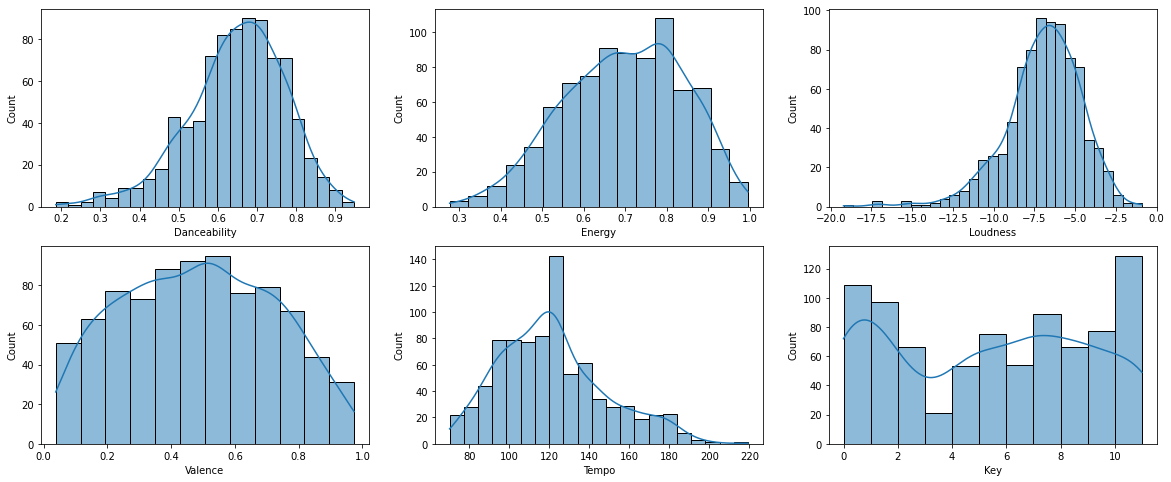

In [20]:
def visualize_playlist(target_playlist):

    top_artists = analyze_artists(target_playlist, target_number=10)
    top_artists_plot = top_artists[1];
    top_artists_plot;

    top_genres = analyze_genres(target_playlist, target_number=10)
    top_genres_plot = top_genres[1];
    top_genres_plot;

    feature_charts = analyze_playlist(target_playlist)
    feature_charts;
    
    return

visualize_playlist(target_playlist)

# Gathering Possible Songs for Reccomendation

We'll start by gathering the related artists

In [94]:
def get_related_artists(artistid):
        
    related_artists = sp.artist_related_artists(artistid)
    
    targetplaylist = pd.DataFrame(related_artists['artists'])
    
    targetplaylist = targetplaylist[['name', 'genres', 'popularity', 'followers', 'external_urls', 'href', 'id', 'images', 'uri', 'type']]

    #targetplaylist = targetplaylist.set_index('id')

    return targetplaylist

def create_related_artists_df(playlistdf, limit = 200):

    id_number = []
    name = []
    genres = []
    popularity = []    
    
    # Keys returned by get_related_artists: 'name', 'genres', 'popularity', 'followers', 'external_urls', 'href','images', 'uri', 'type'
    
    for i in playlistdf['artists_ids']:
        for j in i:
            # Not all artists have related artists so we need add exception handling
            try: 
                related_artists = get_related_artists(j)
                id_number.extend(list(related_artists['id']))
                name.extend(list(related_artists['name']))
                genres.extend(list(related_artists['genres']))
                popularity.extend(list(related_artists['popularity']))
            except:
                pass
            
    artists_repeat_count = []            
            
    related_artists_df = zip(id_number, name, genres, popularity)
    
    related_artists_df = pd.DataFrame(related_artists_df, columns=['id', 'name', 'genres', 'popularity'])
    
    # We'll want to keep track of how many overlapping recommendations were, so we'll add a count of the times the artists are duplicated
    repeat_count = 0
    
    for i in related_artists_df['id']:
        repeat_count = len(related_artists_df[related_artists_df['id'].str.match(i)])
        artists_repeat_count.append(repeat_count)

    related_artists_df['artists_repeat_count'] = artists_repeat_count
    
    related_artists_df = related_artists_df.drop_duplicates(subset=['id'])
    
    # we'll filter for the top repeated artists so we're making too many requests later
    related_artists_df = related_artists_df.sort_values(by='artists_repeat_count', ascending = False)   
    related_artists_df = related_artists_df[0:limit]

    
    return(related_artists_df)            

related_artists_df = create_related_artists_df(target_playlist)
print(related_artists_df.shape)
related_artists_df.head(n=20)

(200, 5)


,id,name,genres,popularity,artists_repeat_count
250,448VwSmqc6SpRDqK5WYXIt,Bronze Whale,"[vapor soul, vapor twitch]",47,13
258,1ikID9RZZMvkuBGDWrqajq,Kasbo,"[edm, electropop, future bass, indie electropo...",56,13
265,1kwGj7uDO5WXVXtQLvGJr0,Just A Gent,"[aussietronica, bass trap, edm, electro house,...",54,12
149,01qbSocTDAe2DmKayS89A5,pluko,"[bass trap, edm, electronic trap, future bass,...",49,12
91,4aCkc4HrwC4Dopig7RELoH,Kidswaste,"[electropop, future bass, indie electropop, va...",50,11


Now that we can gather the related artists, we'll pull their top 10 songs to create a dataframe full of songs from each artist

In [104]:
def get_top_tracks(artistid):
    
    artist_top_tracks = sp.artist_top_tracks(artistid)
    
    name = []
    id_number = []
    artists =[]
    album =[]
    duration_ms = [] 
    popularity = []

    
    for i in range(len(artist_top_tracks['tracks'])):
        id_number.append(artist_top_tracks['tracks'][i]['id'])
        name.append(artist_top_tracks['tracks'][i]['name'])
        artists.append(artist_top_tracks['tracks'][i]['artists'])
        album.append(artist_top_tracks['tracks'][i]['album'])
        duration_ms.append(artist_top_tracks['tracks'][i]['duration_ms'])
        popularity.append(artist_top_tracks['tracks'][i]['popularity'])


    return album, artists, duration_ms, id_number, name, popularity


def create_top_tracks_df(playlistdf):
    
    album =[]
    artists =[]
    duration_ms = []
    id_number = []
    name = []
    popularity = []
    
    for i in list(playlistdf['id']):
        top_tracks = get_top_tracks(i)
        
        album.extend(top_tracks[0])
        artists.extend(top_tracks[1])
        duration_ms.extend(top_tracks[2])
        id_number.extend(top_tracks[3])
        name.extend(top_tracks[4])
        popularity.extend(top_tracks[5])
        
    top_tracks_df = zip(id_number, name, artists, album, popularity, duration_ms)
    
    top_tracks_df = pd.DataFrame(top_tracks_df, columns=['id', 'name', 'artists',  'album', 'popularity', 'duration_ms'])
    
    print(top_tracks_df.shape)
    top_tracks_df = top_tracks_df.drop_duplicates(subset=['id'])
    
    # Drop songs from original playlist
    print(top_tracks_df.shape)
    songs_on_orignal_playlist = list(target_playlist['id'])
    on_original_playlist_mask = ~top_tracks_df['id'].isin(songs_on_orignal_playlist)
    top_tracks_df = top_tracks_df[on_original_playlist_mask]
    
    top_tracks_df = top_tracks_df.reset_index()


    
    return top_tracks_df

top_tracks_df = create_top_tracks_df(related_artists_df)
print(top_tracks_df.shape)
top_tracks_df.head(n=2)


(1965, 6)
(1895, 6)
(1881, 7)


,index,id,name,artists,album,popularity,duration_ms
0,0,5PNRrsoailYvZDIHSnFiaC,Let's Go Walk,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",51,202000
1,1,7JwN3Kb7BHTqasoRE8s9gr,Good Enough,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",49,213391


In [106]:
top_tracks_df = get_artist_info(top_tracks_df)
print(top_tracks_df.shape)
top_tracks_df.head(n=2)

(1881, 28)


,index,id,name,artists,album,popularity,duration_ms,artists_names,artists_ids,artist_name1,artist_name2,artist_name3,artist_name4,artist_name5,artist_name6,artist_name7,artist_name8,artist_name9,artist_name10,artist_name11,artist_name12,artist_name13,artist_name14,artist_name15,artist_name16,artist_name17,artist_name18,artist_name19
0,0,5PNRrsoailYvZDIHSnFiaC,Let's Go Walk,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",51,202000,[Bronze Whale],[448VwSmqc6SpRDqK5WYXIt],Bronze Whale,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,1,7JwN3Kb7BHTqasoRE8s9gr,Good Enough,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",49,213391,[Bronze Whale],[448VwSmqc6SpRDqK5WYXIt],Bronze Whale,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [107]:
top_tracks_df = get_album_info(top_tracks_df)
print(top_tracks_df.shape)
top_tracks_df.head(n=2)

(1881, 32)


,index,id,name,artists,album,popularity,duration_ms,artists_names,artists_ids,artist_name1,artist_name2,artist_name3,artist_name4,artist_name5,artist_name6,artist_name7,artist_name8,artist_name9,artist_name10,artist_name11,artist_name12,artist_name13,artist_name14,artist_name15,artist_name16,artist_name17,artist_name18,artist_name19,album_name,album_id,album_realease_date,album_type
0,0,5PNRrsoailYvZDIHSnFiaC,Let's Go Walk,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",51,202000,[Bronze Whale],[448VwSmqc6SpRDqK5WYXIt],Bronze Whale,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Let's Go Walk,67NzQRs0tvS43cnebet7IZ,2020-02-25,single
1,1,7JwN3Kb7BHTqasoRE8s9gr,Good Enough,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",49,213391,[Bronze Whale],[448VwSmqc6SpRDqK5WYXIt],Bronze Whale,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Good Enough,567tbwXQ71LAMEzzHxWrPZ,2020-10-20,single


In [108]:
top_tracks_df = get_song_genres(top_tracks_df)
print(top_tracks_df.shape)
top_tracks_df.head(n=2)

Spotify calls:  1149 Dict calls:  2194
(1881, 33)


,index,id,name,artists,album,popularity,duration_ms,artists_names,artists_ids,artist_name1,artist_name2,artist_name3,artist_name4,artist_name5,artist_name6,artist_name7,artist_name8,artist_name9,artist_name10,artist_name11,artist_name12,artist_name13,artist_name14,artist_name15,artist_name16,artist_name17,artist_name18,artist_name19,album_name,album_id,album_realease_date,album_type,Artist_Genres
0,0,5PNRrsoailYvZDIHSnFiaC,Let's Go Walk,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",51,202000,[Bronze Whale],[448VwSmqc6SpRDqK5WYXIt],Bronze Whale,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Let's Go Walk,67NzQRs0tvS43cnebet7IZ,2020-02-25,single,"[vapor soul, vapor twitch]"
1,1,7JwN3Kb7BHTqasoRE8s9gr,Good Enough,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",49,213391,[Bronze Whale],[448VwSmqc6SpRDqK5WYXIt],Bronze Whale,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Good Enough,567tbwXQ71LAMEzzHxWrPZ,2020-10-20,single,"[vapor soul, vapor twitch]"


In [109]:
top_tracks_df = get_song_features(top_tracks_df)
print(top_tracks_df.shape)
top_tracks_df.head(n=2)
    

(1881, 45)


,index,id,name,artists,album,popularity,duration_ms,artists_names,artists_ids,artist_name1,artist_name2,artist_name3,artist_name4,artist_name5,artist_name6,artist_name7,artist_name8,artist_name9,artist_name10,artist_name11,artist_name12,artist_name13,artist_name14,artist_name15,artist_name16,artist_name17,artist_name18,artist_name19,album_name,album_id,album_realease_date,album_type,Artist_Genres,danceability,energy,key,mode,speechiness,instrumentalness,acousticness,loudness,liveness,valence,tempo,time_signature
0,0,5PNRrsoailYvZDIHSnFiaC,Let's Go Walk,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",51,202000,[Bronze Whale],[448VwSmqc6SpRDqK5WYXIt],Bronze Whale,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Let's Go Walk,67NzQRs0tvS43cnebet7IZ,2020-02-25,single,"[vapor soul, vapor twitch]",0.696,0.605,10,1,0.145,0.000707,0.6620,-5.524,0.105,0.116,89.965,4
1,1,7JwN3Kb7BHTqasoRE8s9gr,Good Enough,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",49,213391,[Bronze Whale],[448VwSmqc6SpRDqK5WYXIt],Bronze Whale,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Good Enough,567tbwXQ71LAMEzzHxWrPZ,2020-10-20,single,"[vapor soul, vapor twitch]",0.802,0.609,5,0,0.085,0.009870,0.0427,-5.660,0.238,0.274,114.996,4


In [111]:
top_tracks_df.tail()

,index,id,name,artists,album,popularity,duration_ms,artists_names,artists_ids,artist_name1,artist_name2,artist_name3,artist_name4,artist_name5,artist_name6,artist_name7,artist_name8,artist_name9,artist_name10,artist_name11,artist_name12,artist_name13,artist_name14,artist_name15,artist_name16,artist_name17,artist_name18,artist_name19,album_name,album_id,album_realease_date,album_type,Artist_Genres,danceability,energy,key,mode,speechiness,instrumentalness,acousticness,loudness,liveness,valence,tempo,time_signature
1876,1960,1wBI4eoyEYa0FctRANNnPL,Collapse,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",42,198400,"[Pixel Terror, neverwaves]","[3DajvNySJjylWpCSeXefFm, 2js39lyEUjoD0x3VxshU5o]",Pixel Terror,neverwaves,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Collapse,6wGNr7jh9jEiyoRA1FABHN,2020-02-06,single,"[edm, electro house, future bass, gaming edm, ...",0.468,0.609,5,0,0.0349,0.000002,0.1190,-4.126,0.0740,0.409,75.026,4
1877,1961,4QXYBGEATD3XN91dIS57Rx,Sleepless,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",41,230654,"[Pixel Terror, Chime, Teminite]","[3DajvNySJjylWpCSeXefFm, 3hMTYaexWgGkXqvbkt6EI...",Pixel Terror,Chime,Teminite,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Sleepless,0mfBVDHwB7RyTVTyndyv04,2021-06-10,single,"[edm, electro house, future bass, gaming edm, ...",0.482,0.865,5,0,0.1280,0.000330,0.0394,-3.049,0.0937,0.391,149.895,4
1878,1962,2zVg53xdC6RMpthWju6LRT,Contra,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",39,238080,"[Pixel Terror, Sara Skinner]","[3DajvNySJjylWpCSeXefFm, 1HQ26IHQ1Nu0Tq7EE7DV6y]",Pixel Terror,Sara Skinner,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Contra,5230ACTz8mDl7SbGBkWYjO,2018-09-06,single,"[edm, electro house, future bass, gaming edm, ...",0.657,0.789,2,1,0.0857,0.000271,0.0628,-4.351,0.1410,0.209,125.028,4
1879,1963,4sqm7DfJahBVXPYJNtcVn4,Move 4 Me,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",36,154956,[Pixel Terror],[3DajvNySJjylWpCSeXefFm],Pixel Terror,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Move 4 Me,0joLOD6HuRmJZ9qgO0zwwM,2021-09-23,single,"[edm, electro house, future bass, gaming edm, ...",0.697,0.514,1,1,0.0613,0.000008,0.1490,-6.276,0.0649,0.689,115.229,4
1880,1964,1e4VuceNyO8lxcrA0nX0MW,Carbonara,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",36,172800,"[Pixel Terror, Spag Heddy]","[3DajvNySJjylWpCSeXefFm, 043Bey7ngSGRFpJftAlKpi]",Pixel Terror,Spag Heddy,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Carbonara,1VxhQYQGPWGOrH2l61pYG8,2021-11-15,single,"[edm, electro house, future bass, gaming edm, ...",0.602,0.968,11,0,0.1120,0.011700,0.0024,-2.685,0.3890,0.444,150.015,4


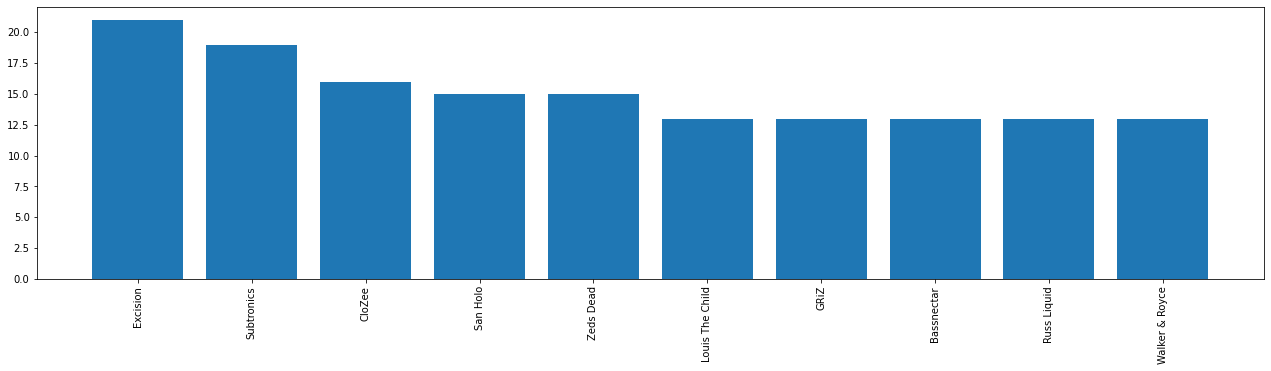

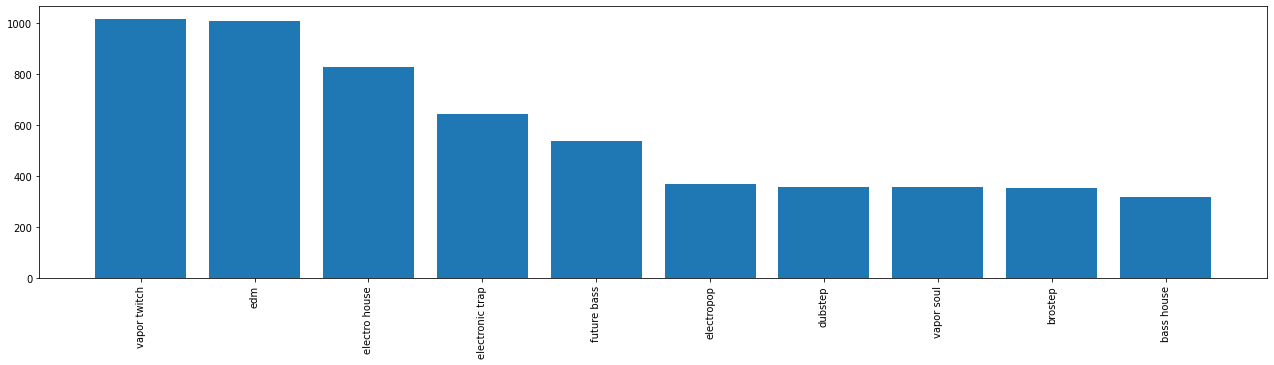

<Figure size 1008x720 with 0 Axes>

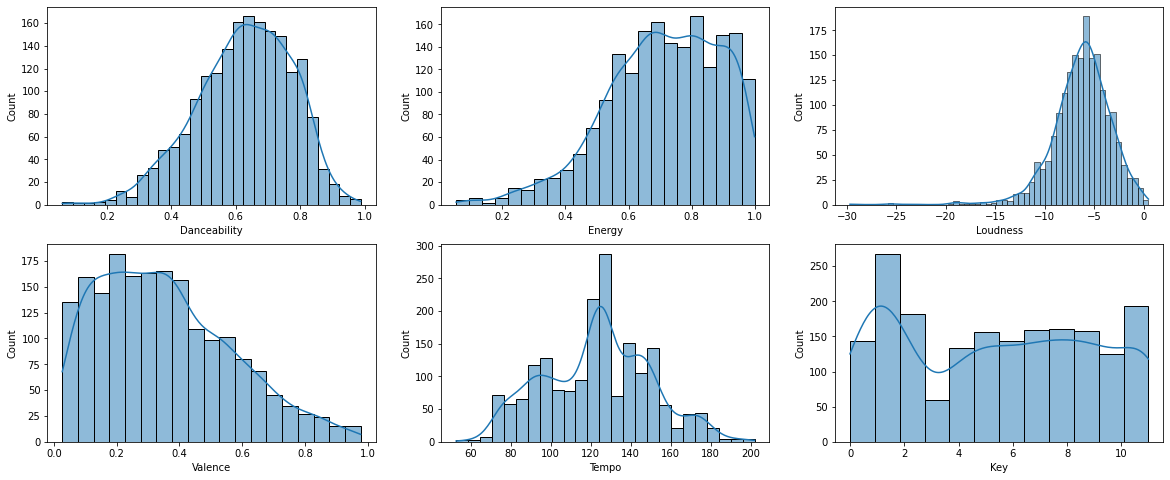

In [112]:
visualize_playlist(top_tracks_df)


# Cosine Similiarity

In [115]:
def get_cosine_similarity_score(playlist_df, comparision_df):
    
    feature_cols=['acousticness', 'danceability', 'duration_ms', 'energy',
                  'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
                  'speechiness', 'tempo', 'time_signature', 'valence']

    scaler = StandardScaler()
    
    # drop songs without features data
    playlist_df = playlist_df.dropna(subset=feature_cols)

    
    playlist_df_features = playlist_df[feature_cols]
    playlist_df_features[feature_cols] = scaler.fit_transform(playlist_df_features)
    playlist_df_features[feature_cols] = np.array(playlist_df_features[feature_cols], dtype=float)
    
    
    comparision_df_features = comparision_df[feature_cols] 
    comparision_df_features[feature_cols] = scaler.fit_transform(comparision_df_features)


    target_vector = list(comparision_df_features.mean())

    cosine_similarity_score = []

    for i in range(len(playlist_df_features)): 
        vector = list(playlist_df_features.iloc[i])
        score = cosine_similarity([vector], [target_vector])
        cosine_similarity_score.append(float(score))
        
    playlist_df['cosine_similarity'] = cosine_similarity_score
    
    playlist_df = playlist_df.sort_values(by='cosine_similarity', ascending=False)
    
    return playlist_df

top_tracks_df = get_cosine_similarity_score(top_tracks_df, target_playlist)
print(top_tracks_df.shape)
top_tracks_df.head(n=2)

(1881, 47)


,index,id,name,artists,album,popularity,duration_ms,artists_names,artists_ids,artist_name1,artist_name2,artist_name3,artist_name4,artist_name5,artist_name6,artist_name7,artist_name8,artist_name9,artist_name10,artist_name11,artist_name12,artist_name13,artist_name14,artist_name15,artist_name16,artist_name17,artist_name18,artist_name19,album_name,album_id,album_realease_date,album_type,Artist_Genres,danceability,energy,key,mode,speechiness,instrumentalness,acousticness,loudness,liveness,valence,tempo,time_signature,All_artists,cosine_similarity
590,605,5pGw7SFs5xQbna578icJU8,Silo (feat. fknsyd),[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",41,247500,"[RL Grime, Hex Cougar, fknsyd]","[5eIbEEQnDM8yuDVB0bimSP, 0AlNB0yIoyxdKloLmK9AO...",RL Grime,Hex Cougar,fknsyd,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Silo (feat. fknsyd),1WLpL8WgAQfFIzsfB9NFAu,2022-09-02,single,"[bass trap, edm, electro house, electronic tra...",0.472,0.933,5,0,0.195,0.3670,0.063200,-4.985,0.0678,0.326,159.949,4,"[RL Grime, Hex Cougar, fknsyd, None, None, Non...",0.694149
809,843,0cfzsbbOnqe8Ly6quaBKDk,Mac 19,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",49,209655,[Rusko],[4BTcOR2hEQZQQL5AMo5u10],Rusko,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Mac 19,3o5z18YGRU28DOYMRlmQyK,2021-07-16,single,"[bassline, brostep, classic dubstep, edm, elec...",0.590,0.890,6,1,0.080,0.0118,0.000403,-5.348,0.1050,0.486,174.005,4,"[Rusko, None, None, None, None, None, None, No...",0.680699


In [116]:
def create_recommendations(playlist_df, engine='cosine_similarity', number_of_songs=40):
    
    playlist_df = playlist_df.sort_values(by=engine, ascending=False)

    recommended_playlist = top_tracks_df.iloc[0:number_of_songs]
    
    recommended_playlist = recommended_playlist.reset_index()

    
    return recommended_playlist

recommended_playlist = create_recommendations(top_tracks_df, number_of_songs=100)
print(recommended_playlist.shape)
recommended_playlist.head()

(100, 48)


,level_0,index,id,name,artists,album,popularity,duration_ms,artists_names,artists_ids,artist_name1,artist_name2,artist_name3,artist_name4,artist_name5,artist_name6,artist_name7,artist_name8,artist_name9,artist_name10,artist_name11,artist_name12,artist_name13,artist_name14,artist_name15,artist_name16,artist_name17,artist_name18,artist_name19,album_name,album_id,album_realease_date,album_type,Artist_Genres,danceability,energy,key,mode,speechiness,instrumentalness,acousticness,loudness,liveness,valence,tempo,time_signature,All_artists,cosine_similarity
0,590,605,5pGw7SFs5xQbna578icJU8,Silo (feat. fknsyd),[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",41,247500,"[RL Grime, Hex Cougar, fknsyd]","[5eIbEEQnDM8yuDVB0bimSP, 0AlNB0yIoyxdKloLmK9AO...",RL Grime,Hex Cougar,fknsyd,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Silo (feat. fknsyd),1WLpL8WgAQfFIzsfB9NFAu,2022-09-02,single,"[bass trap, edm, electro house, electronic tra...",0.472,0.933,5,0,0.1950,0.3670,0.063200,-4.985,0.0678,0.326,159.949,4,"[RL Grime, Hex Cougar, fknsyd, None, None, Non...",0.694149
1,809,843,0cfzsbbOnqe8Ly6quaBKDk,Mac 19,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",49,209655,[Rusko],[4BTcOR2hEQZQQL5AMo5u10],Rusko,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Mac 19,3o5z18YGRU28DOYMRlmQyK,2021-07-16,single,"[bassline, brostep, classic dubstep, edm, elec...",0.590,0.890,6,1,0.0800,0.0118,0.000403,-5.348,0.1050,0.486,174.005,4,"[Rusko, None, None, None, None, None, None, No...",0.680699
2,723,746,7r5dj3XCojWuJ3iv9OfKi2,Bring Forth The Pressure,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",41,165333,"[ILLENIUM, Dirt Monkey]","[45eNHdiiabvmbp4erw26rg, 5dNqUwGTZcQQ09ecTKkCGH]",ILLENIUM,Dirt Monkey,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Bring Forth The Pressure - Single,14S824jumt0PYlNqL9FWtO,2016-05-06,single,"[edm, melodic dubstep, pop, pop dance, tropica...",0.607,0.949,4,1,0.0969,0.2040,0.001940,-3.122,0.0891,0.239,180.033,4,"[ILLENIUM, Dirt Monkey, None, None, None, None...",0.678428
3,371,381,0O3BhnAuIuQy30OVINfFLz,Just Lost - Tsu Nami Remix,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",22,204705,"[juuku, Manila Killa, Tsu Nami]","[2ixBQngmF4ZFXYHi8sJTfl, 4EukMPjtYsdi87lkU1hIx...",juuku,Manila Killa,Tsu Nami,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Just Lost (The Remixes),7MMVIqj6QDn5iNKd5WHCC4,2021-06-11,single,"[future bass, vapor twitch, edm, electropop, f...",0.497,0.945,10,1,0.0811,0.4430,0.008800,-6.653,0.1690,0.325,170.012,4,"[juuku, Manila Killa, Tsu Nami, None, None, No...",0.669712
4,1147,1201,3fqWMqLjDxzOdQpWKED0KD,Cold Day in Hell,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'single', 'artists': [{'externa...",45,144000,"[NITTI, Dr. Fresch]","[21AUdblPrTRzkvJn8FGrlk, 1htHgbGwgCWJBfGiQwcRqC]",NITTI,Dr. Fresch,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Cold Day in Hell,22D6EmHSGRK9jG9mOdXkGn,2020-12-01,single,"[bass house, brostep, dubstep, edm, electro ho...",0.650,0.868,11,0,0.0838,0.2220,0.082700,-4.785,0.1250,0.445,200.143,4,"[NITTI, Dr. Fresch, None, None, None, None, No...",0.663375


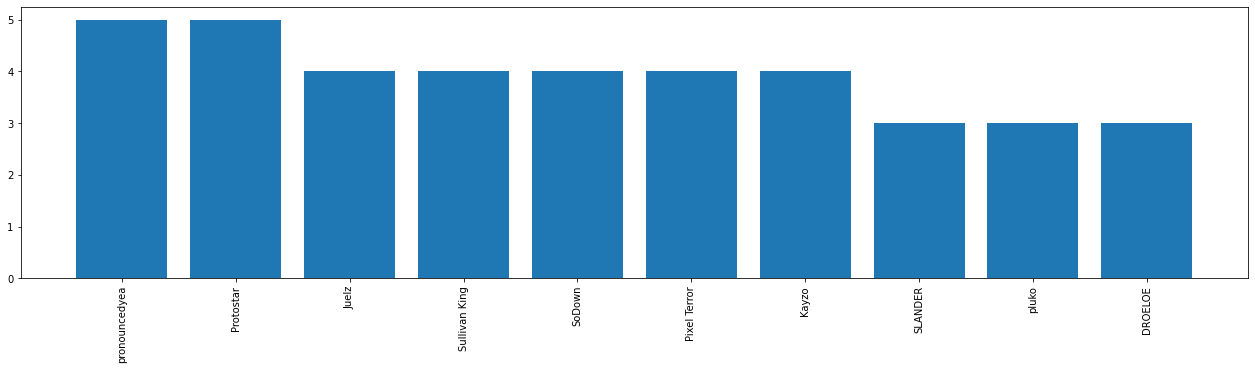

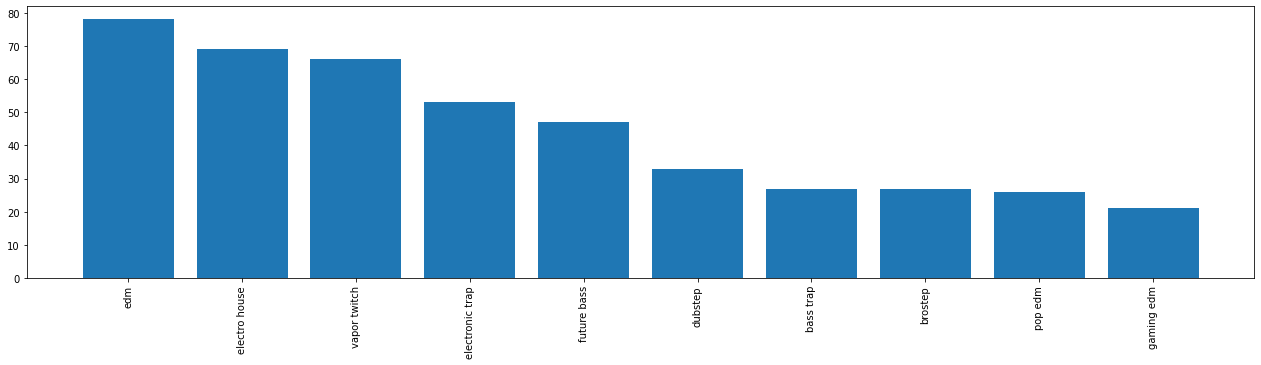

<Figure size 1008x720 with 0 Axes>

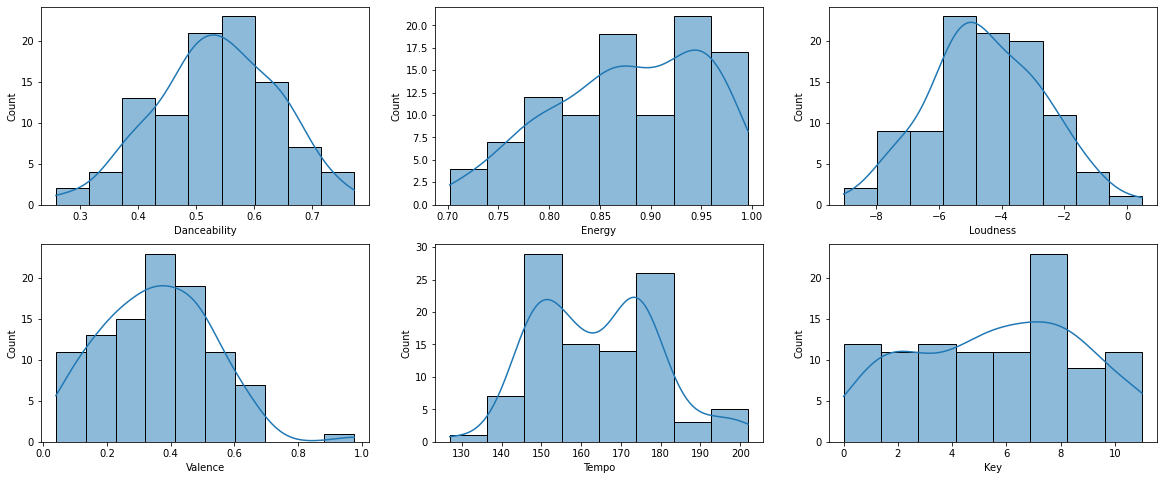

In [117]:
visualize_playlist(recommended_playlist)


In [118]:
def generate_playlist(playlist_df, playlist_name='Test Playlist', replace_tracks=False, public=True, collaborative=False):
    
    user_playlists = get_user_playlists()
    playlist_id =''
    
    if playlist_name in user_playlists.keys():
        playlist_id = user_playlists[playlist_name]
    else:
        sp.user_playlist_create(username, playlist_name, public=public, collaborative=collaborative, description='')
        user_playlists = get_user_playlists()
        playlist_id = user_playlists[playlist_name]

    if replace_tracks == True:
        sp.user_playlist_replace_tracks(username, playlist_id, list(playlist_df['id']))
    else:
        sp.user_playlist_add_tracks(username, playlist_id, list(playlist_df['id']), position=None)
        
    print('Created New Playlist: ', playlist_name)
 
    return

generate_playlist(recommended_playlist, playlist_name='Test Playlist 2', replace_tracks=True)

    

Created New Playlist:  Test Playlist 2


## Gathering all of an artists songs

The top ten songs are a great start, but we may want to be able to dig a little deeper into each artists' catalog. These functions pulls all of an artists songs into a dataframe

In [ ]:
def get_albums(artistid):
    
    album_id = []
    album_name = []
    ablum_artists = []
    album_type = []
    album_release_date = []
    
    artist_albums = sp.artist_albums(artistid)

    
    for j in range(len(artist_albums['items'])):
        album_id.append(artist_albums['items'][j]['id'])
        album_type.append(artist_albums['items'][j]['album_type'])
        album_name.append(artist_albums['items'][j]['name'])
        ablum_artists.append(artist_albums['items'][j]['artists'])
        album_release_date.append(artist_albums['items'][j]['release_date'])
            
    return album_id, album_name, ablum_artists, album_type, album_release_date

            
def create_albums_df(playlistdf):
   
    id_number = []
    name =[]
    artists =[]
    album_type = []
    name = []
    release_date = []
    
   
    for i in playlistdf['id']:
                
        albums = get_albums(i)
        
        id_number.extend(albums[0])
        name.extend(albums[1])
        artists.extend(albums[2])
        album_type.extend(albums[3])
        release_date.extend(albums[4])
        
    albums_df = zip(id_number, name, artists, album_type, release_date)
    
    albums_df = pd.DataFrame(albums_df, columns=['id', 'name', 'artists',  'album_type', 'release_date'])
    
    return albums_df
    
albums_df = create_albums_df(related_artists_df)
print(albums_df.shape)
albums_df.head()

In [ ]:
def get_album_tracks(playlistdf):
    
    # we need to able to expand our dataframe if there's more than one song on an album
    # so we'll turn our columns into lists and append them as we itterate through the albums
    id_number_list = list(playlistdf['id'])
    album_name_list = list(playlistdf['name'])
    artists_list = list(playlistdf['artists'])
    album_type_list = list(playlistdf['album_type'])
    album_release_date_list = list(playlistdf['release_date'])

    
    album_id = []
    album_name = []
    album_artists = []
    album_type = []
    album_release_date = []
    
    song_id= []
    song_name = []
    song_duration = []
    song_artists = []   
    
        
    for i, j in enumerate(playlistdf['id']):
        
        album_info = sp.album_tracks(j)
        # available fields 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_urls', 'href', 'id', 'is_local', 'name', 'preview_url', 'track_number', 'type', 'uri'
        
        for k in range(len(album_info['items'])):          
            album_id.append(id_number_list[i])
            album_name.append(album_name_list[i])
            album_artists.append(artists_list[i])
            album_type.append(album_type_list[i])
            album_release_date.append(album_release_date_list[i])
        
            song_id.append(album_info['items'][k]['id'])
            song_name.append(album_info['items'][k]['name'])
            song_duration.append(album_info['items'][k]['duration_ms'])
            song_artists.append(album_info['items'][k]['artists'])
            
    playlistdf = zip(song_id, song_name, song_artists, album_name, album_id, album_artists, album_type, album_release_date, song_duration)
    
    playlistdf = pd.DataFrame(playlistdf, columns=['id', 'name', 'artists', 'album_name', 'album_id', 'album_artists', 'album_type', 'album_release_date', 'song_duration', ])
       
    return playlistdf    


    
    
    

In [ ]:
songs_df = get_artist_info(songs_df.sample(100))
songs_df = get_song_genres(songs_df)
songs_df = get_album_info(songs_df)
songs_df = get_song_features(songs_df)
print(songs_df.shape)
songs_df.head()